In [95]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [96]:
#### Preprocecing ###

In [97]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [98]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df

In [99]:
epoch = pd.to_datetime('2020-02-01')

In [100]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[epoch:, contries]
confirmed = confirmed.cummax()

In [101]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.loc[epoch:, contries]
recovered = recovered.cummax()


In [102]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.loc[epoch:, contries]
death = death.cummax()

In [103]:
### Data Preparation ###

In [104]:
country = 'United Kingdom'
C0 = confirmed[country].values
R0 = (recovered)[country].values
D0 = death[country].values
P = 6665_0000
iter=100000
repeat = 1000

In [105]:
data = {'T': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}

In [106]:
### Model ###

In [107]:
sm = pystan.StanModel(file="turzin.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7ba6d17563748454d8034e538402909e NOW.


In [108]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=iter, init=0)

In [109]:
fit

Inference for Stan model: anon_model_7ba6d17563748454d8034e538402909e.
4 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=200000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   1.58  6.7e-3   1.23   0.15   0.68   1.28   2.15   4.74  33667    1.0
b0         2.69  5.7e-3   0.63   1.82   2.26   2.57   2.98   4.27  12560    1.0
b1         0.04  2.1e-4 2.2e-3   0.04   0.04   0.04   0.04   0.04    112   1.02
theta_b     2.4  8.6e-3   1.32   0.82   1.44   2.06    3.0    5.8  23400    1.0
b_date     9.75  6.9e-3   0.78   7.75   9.41   9.91  10.25  10.88  12595    1.0
q1         0.62  1.4e-3   0.25   0.12   0.43   0.65   0.83   0.98  30146    1.0
theta_q    0.22  1.2e-5 2.1e-3   0.21   0.21   0.22   0.22   0.22  29109    1.0
q_date    55.52  2.4e-3    0.3  54.92  55.31  55.52  55.72  56.11  16115    1.0
a        7.0e-4  2.9e-4 4.1e-4  1e-15 3.5e-4 9.2e-4 9.5e-4 1.0e-3      2  13.44
d    

In [110]:
### Visualization functions ###

In [111]:
def sigmoid(x, theta, t0):
    return 1/(1 + np.exp(-theta*(x-t0)))

In [112]:
def simulate(init_inf, b0, b1, theta_b, b_date, q1, theta_q, q_date, a, d, horizon):
    S = init_inf;
    R = 0;
    D = 0;
    S_list = [S]
    R_list = [R]
    D_list = [D]
    b_list = [b0]
    q_list = [0]
    S0 = [0]
    R0 = [0]
    D0 = [D]
    for t in range(horizon):
        b = b0 + (b1-b0) * sigmoid(t, theta_b, b_date)
        I = (S - R - D) * b * (1 - S/P)
        q = q1 * sigmoid(t, theta_q, q_date)
        NR = a * (S - R - D)
        ND = d * (S - R - D)
        D = D + ND
        S = S + I
        R = R + NR
        S_list.append(S)
        R_list.append(R)
        D_list.append(D)
        b_list.append(b)
        q_list.append(q)
        S0.append(S0[-1]+q*I)
        R0.append(R0[-1]+a * (S0[-1] - R0[-1] - D0[-1]))
    data = pd.DataFrame({'S':np.array(S_list),
                        'R':np.array(R_list),
                        'D':np.array(D_list),
                        'b':np.array(b_list),
                        'q':np.array(q_list),
                        'S0':np.array(S0),
                        'R0':np.array(R0)},
                        index=pd.date_range(start=epoch, periods=horizon+1, freq='D'))
    return data

In [113]:
def monte_carlo(fit, horizon):
    S = pd.DataFrame()
    R = pd.DataFrame()
    D = pd.DataFrame()
    b = pd.DataFrame()
    q = pd.DataFrame()
    S0 = pd.DataFrame()
    R0 = pd.DataFrame()
    I0 = pd.DataFrame()
    n = fit['init_inf'].shape[0]
    for k in range(repeat):
        i = np.random.randint(n)
        df = simulate(init_inf=fit['init_inf'][i],
                      b0=fit['b0'][i],
                      b1=fit['b1'][i],
                      theta_b=fit['theta_b'][i],
                      b_date=fit['b_date'][i],
                      q1=fit['q1'][i],
                      theta_q=fit['theta_q'][i],
                      q_date=fit['q_date'][i],
                      a=fit['a'][i],
                      d=fit['d'][i],
                      horizon=horizon)
        S = pd.concat([S, df['S']], axis=1)
        R = pd.concat([R, df['R']], axis=1)
        D = pd.concat([D, df['D']], axis=1)
        b = pd.concat([b, df['b']], axis=1)
        q = pd.concat([q, df['q']], axis=1)
        S0 = pd.concat([S0, df['S0']], axis=1)
        R0 = pd.concat([R0, df['R0']], axis=1)
        I0 = pd.concat([I0, df['S0'] - df['R0']], axis=1)
    return S, R, D, b, q, S0, R0, I0
    

In [114]:
def extract_series(fit, name):
    value_list = []
    for d in range(S0.shape[0]):
        vals = fit['{}[{}]'.format(name, d+1)]
        value_list.append(vals)
    data = np.array(value_list)
    return pd.DataFrame(data, 
                        index=confirmed.index)

In [115]:
def draw(simulated, real=None):
    graph=pd.DataFrame()
    simulated = simulated.dropna(axis=1)
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", data=graph, aspect=2)

In [116]:
S, R, D, b, q, S0, R0, I0 = monte_carlo(fit, 120)

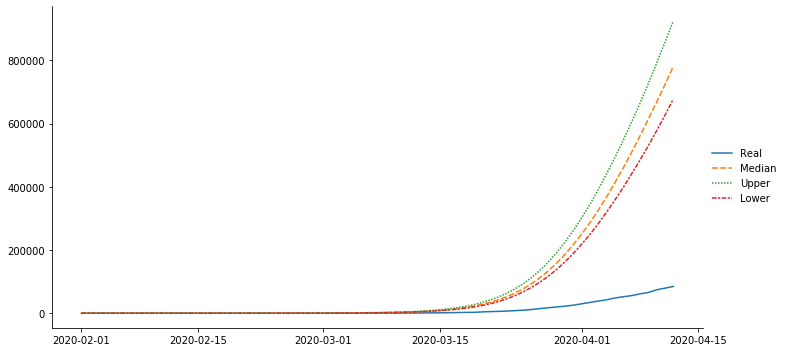

In [117]:
draw(I0, real=(confirmed-recovered)[country])

In [118]:
S.median(axis=1)[pd.to_datetime('2020-04-12')]

4489732.088258529

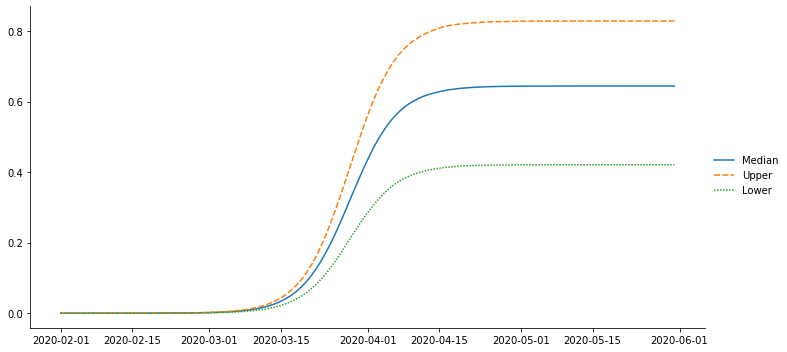

In [119]:
draw(q)

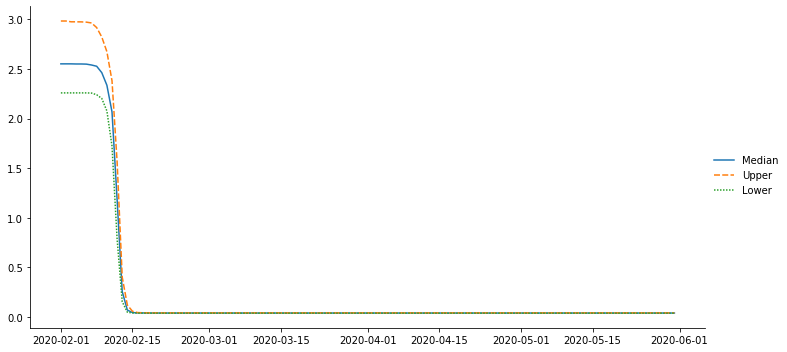

In [120]:
draw(b)

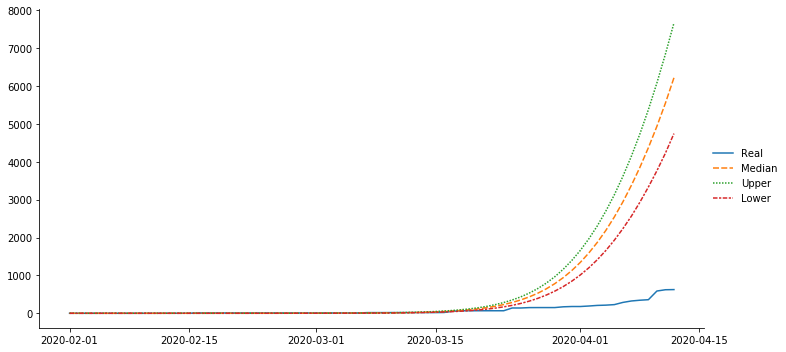

In [121]:
draw(R0, real=recovered[country])

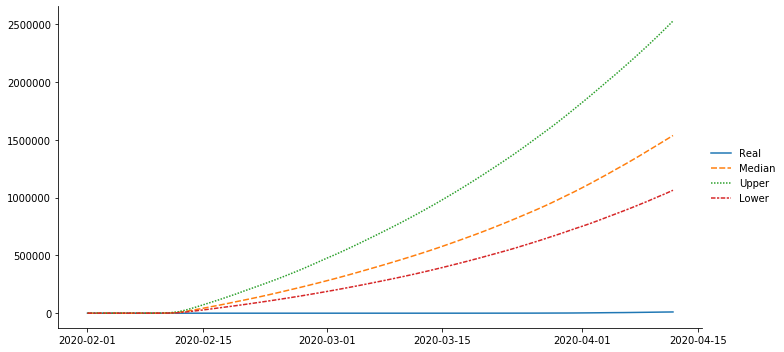

In [122]:
draw(D, real=death[country])

In [123]:
cumulative = pd.DataFrame(S.values, columns=range(len(S.columns)), index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=120+1, freq='D'))

In [124]:
predicted_recovered = pd.DataFrame(R.values, columns=range(len(R.columns)), index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=120+1, freq='D'))

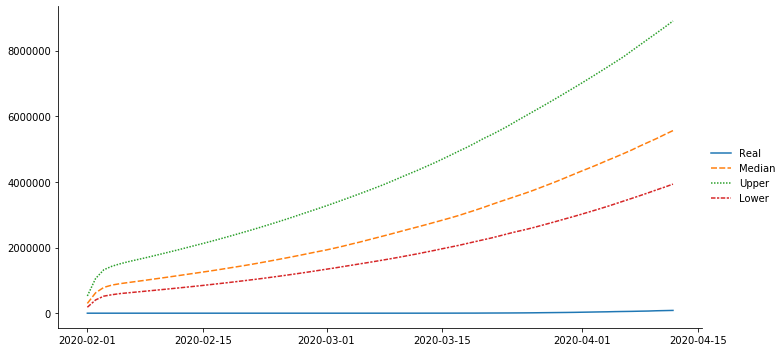

In [125]:
draw(cumulative - predicted_recovered, real=(confirmed-recovered)[country])

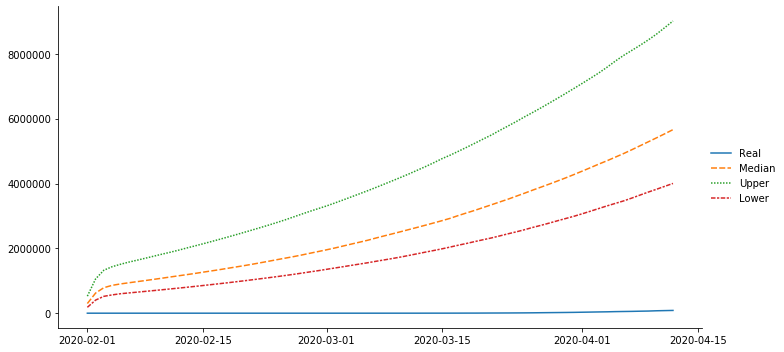

In [126]:
draw(cumulative, real=confirmed[country])

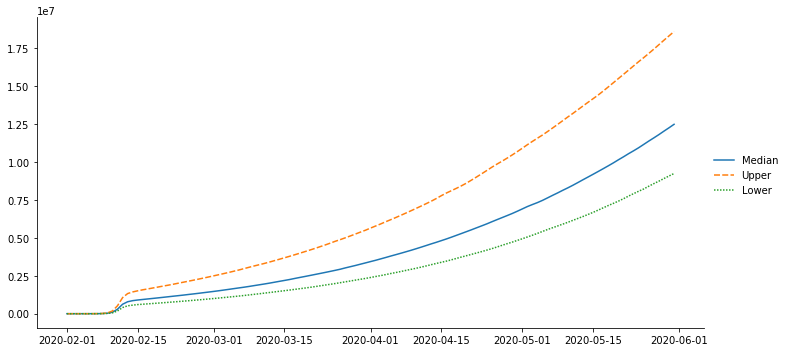

In [127]:
draw(S)

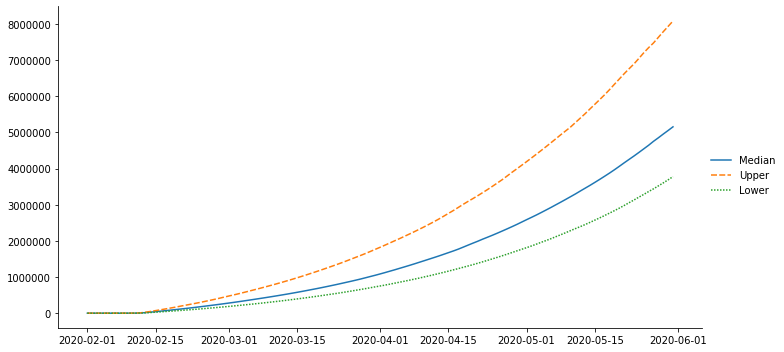

In [128]:
draw(D)

In [129]:
pd.to_datetime('2020-01-22') + pd.Timedelta(days=70)

Timestamp('2020-04-01 00:00:00')

In [130]:
epoch

Timestamp('2020-02-01 00:00:00')